# Demo on GPR

In [1]:
import os,nbloader,warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from demo_util import nzr,data4regression
%config InlineBackend.figure_format = 'retina'
%matplotlib inline  
if __name__ == "__main__":
    print ("Packages Loaded")

Packages Loaded


### Define a Kernel Function

In [2]:
def kernel_se(_X1,_X2,_hyp={'gain':1,'len':1,'s2w':1e-8},_use_s2w=False):
    hyp_gain = float(_hyp['gain'])**2
    hyp_len  = 1/float(_hyp['len'])
    if len(_X1.shape)<=1: _X1=_X1.reshape((-1,1))
    if len(_X2.shape)<=1: _X2=_X2.reshape((-1,1))
    pairwise_dists = cdist(_X1,_X2,'euclidean')
    K = hyp_gain*np.exp(-pairwise_dists ** 2/(hyp_len**2))
    if _use_s2w:
        K = K + _hyp['s2w']*np.eye(_X1.shape[0])
    return K

class gpr(object):
    def __init__(self,_xTr,_yTr,_hyp):
        self.xTr = _xTr
        self.yTr = _yTr
        self.hyp = _hyp
        self.nzrX = nzr(self.xTr)
        self.nzrY = nzr(self.yTr)
        self.K_TrTr = kernel_se(self.xTr,self.xTr,_hyp=self.hyp,_use_s2w=True)
        self.alpha = np.matmul(np.linalg.inv(self.K_TrTr),self.yTr)
    def inference(self,_xTe):
        self.xTe = _xTe
        self.K_TeTr = kernel_se(self.xTe,self.xTr,_hyp=self.hyp)
        self.K_TeTe = kernel_se(self.xTe,self.xTe,_hyp=self.hyp)
        self.yTe = np.matmul(self.K_TeTr,self.alpha)
        _varTe = self.K_TeTe - np.matmul(np.matmul(self.K_TeTr,
                        np.linalg.inv(self.K_TrTr)),self.K_TeTr.T)
        _varTe = np.diag(_varTe).reshape((-1,1))
        self.varTe = np.sqrt(_varTe)
        
if __name__ == "__main__":
    print ("Kernel function defined.")

Kernel function defined.


### Run GPR

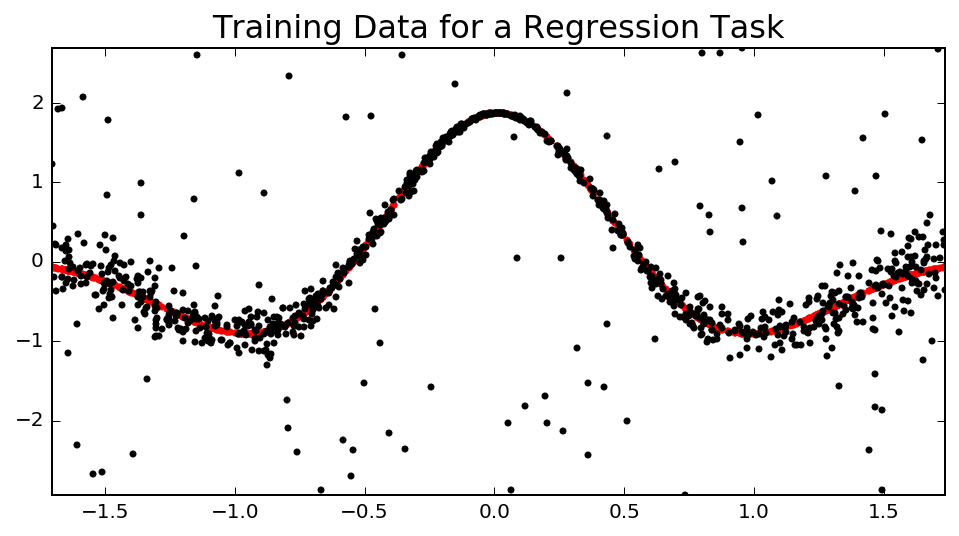

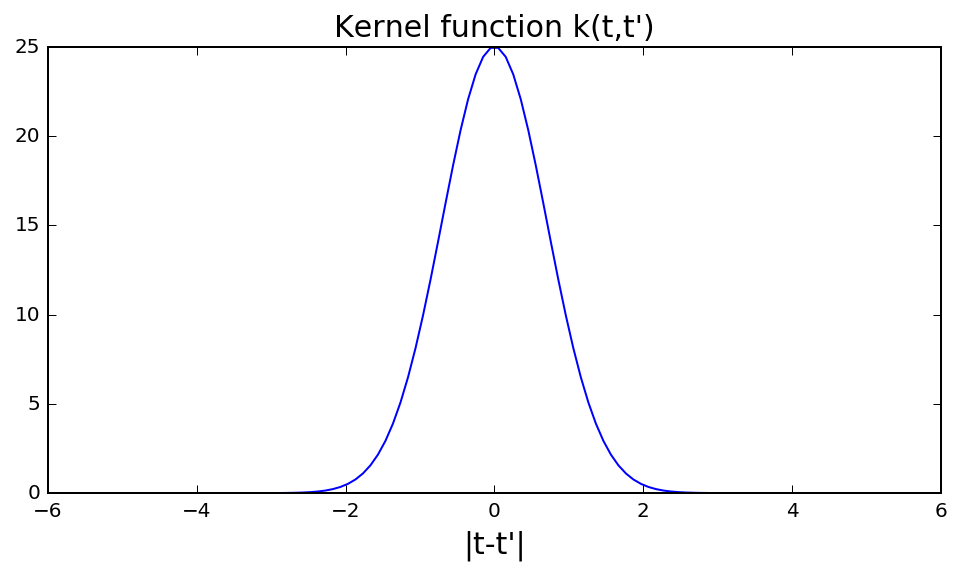

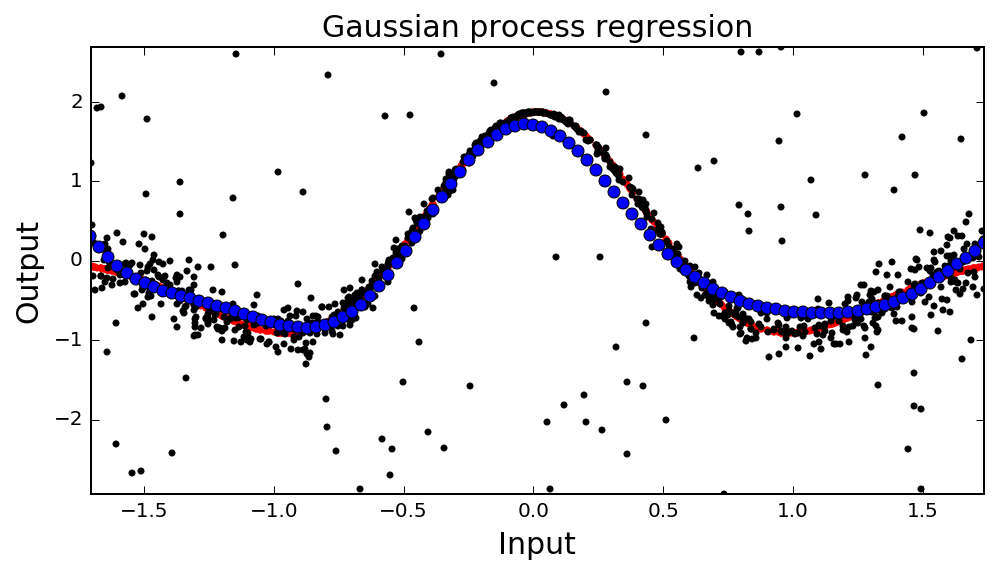

In [4]:
if __name__ == "__main__":
    # Training data
    # Training Data
    xmin,xmax = -3,+3
    xdata,ydata,yref = data4regression(_n=1000,_xmin=xmin,_xmax=+xmax,_outlierRate=0.1)
    nzrX = nzr(xdata); xdata = nzrX.get_nzdval(xdata); 
    ydata,yref = ydata[:,0:1],yref[:,0:1] # Use first dimension only
    nzrY = nzr(ydata); ydata = nzrY.get_nzdval(ydata); yref = nzrY.get_nzdval(yref)
    # Plot training data
    plt.figure(figsize=(8,4)),plt.axis([np.min(xdata),np.max(xdata),np.min(ydata),np.max(ydata)])
    plt.plot(xdata,yref,'r.'); plt.plot(xdata,ydata,'k.')
    plt.title('Training Data for a Regression Task',fontsize=16); plt.show()
    
    # Do inference
    hyp={'gain':5,'len':1./1.,'s2w':1e-2}
    G = gpr(_xTr=xdata,_yTr=ydata,_hyp=hyp)
    nTe = 100
    xTe = np.array([np.linspace(xmin,xmax,nTe)]).T
    xTe = nzrX.get_nzdval(xTe)
    G.inference(_xTe=xTe)

    # Plot kernel function
    plt.figure(figsize=(8,4))
    a = np.linspace(-5,5,nTe).reshape((-1,1))
    b = kernel_se(np.zeros(1),a,_hyp=hyp).reshape((-1,1))
    plt.plot(a,b); plt.xlabel("|t-t'|",fontsize=15)
    plt.title("Kernel function k(t,t')",fontsize=15)
    
    # Plot GPR results
    plt.figure(figsize=(8,4)),plt.axis([np.min(xdata),np.max(xdata),np.min(ydata),np.max(ydata)])
    plt.fill_between(G.xTe.squeeze(),(G.yTe-2.0*G.varTe).squeeze(),(G.yTe+2.0*G.varTe).squeeze(),
                facecolor='g', interpolate=True, alpha=0.1)
    plt.plot(xdata,yref,'r.'); 
    plt.plot(G.xTr[:,0],G.yTr[:,0],'k.',label='Original data')
    plt.plot(G.xTe,G.yTe,'bo');
    plt.xlabel('Input',fontsize=15);plt.ylabel('Output',fontsize=15)
    plt.title('Gaussian process regression',fontsize=15)